# Homework 4

# Задача №1 - Лего детальки

Имеется 2 выборки из датасета фотографий лего картинок. Структура одной выборки следующая:
```
test
| -- 'target.jpg'
| -- source
|    | -- '*.jpg'
|           ...
|    | -- '*.jpg'
```
В выборке есть опорное изображение - target.jpg и набор из 20 картинок в папке source.

Ваша задача - написать программу, которая прочитает все изображения и определит на каких изображениях из папки source сфотографирована такая же лего деталька, что и деталь в target.jpg

Результатом выполнения программы должен быть файлик с названиями подходящих изображений. Пример в Datasets/gt
Снизу представлены 2 вспомогательные функции: чтение всех изображений из папки и посчет получившихся метрик точности

Результат выполнения данной задачи напрямую зависит от полученных метрик. Полученные метрики будут вычисляться из метрик по двум тестам $Accuracy=min({Accuracy}_{test1}, {Accuracy}_{test2}$)

| Accuracy | Recall | % Выполнения |
|:--------:|:------:|:------------:|
|< 0.6|< 0.4|0%|
|  >= 0.6  | >= 0.4 |     75%      |
|  >= 0.7  | >= 0.5 |     100%     |
|  >= 0.9  | >= 0.8 |     150%     |

<table><tr>
    <td> <img src="Datasets/test1/target.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="Datasets/test2/target.jpg" alt="Drawing" style="width: 400px;"/> </td>

</tr></table>

In [10]:
import cv2
from pathlib import Path
import os

In [45]:
def read_all_image_paths(folder):
    folder = Path(folder)
    image_paths = [str(i) for i in folder.glob('*.jpg')]
    return image_paths

def compare_images(img1_path, img2_path):
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    if img1 is None or img2 is None:
        return 0 

    sift = cv2.SIFT_create()

    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    if des1 is None or des2 is None:
        return 0

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    return len(good_matches)

def find_matching_images(target_path, source_folder, output_file, threshold=10):
    source_images = read_all_image_paths(source_folder)
    results = []

    for source_image in source_images:
        similarity_score = compare_images(target_path, source_image)
        if similarity_score > threshold:
            results.append(Path(source_image).name)

    with open(output_file, 'w') as f:
        for result in results:
            f.write(result + '\n')

def return_metrics(gt_path, prediction_path):
    with open(gt_path) as f:
        gt = set([i.strip('\n') for i in f.readlines() if len(i)])
    with open(prediction_path) as f:
        pred = set([i.strip('\n') for i in f.readlines() if len(i)])

    len_dataset = 20

    TP, TN, FP, FN = (0, ) * 4
    for i in pred:
        if i in gt:
            TP += 1
            gt.remove(i)
        else:
            FP += 1
    FN = len(gt)
    TN = len_dataset - TP - FP - FN

    accuracy = (TP + TN) / len_dataset
    recall = TP / (TP + FN)

    print(f'Acc: {accuracy:.2f}')
    print(f'Recall: {recall:.2f}')

In [46]:
base_path = Path(os.path.abspath('')) / 'Datasets' / 'test1'
target_image = base_path / 'target.jpg'
source_folder = base_path / 'source'
output_file = Path(os.path.abspath('')) / 'test1.txt'

find_matching_images(target_image, source_folder, output_file, threshold=10)

gt_path = Path(os.path.abspath('')) / 'Datasets' / 'gt' / 'test1.txt'
return_metrics(gt_path, output_file)

Acc: 0.90
Recall: 0.50


In [47]:
base_path = Path(os.path.abspath('')) / 'Datasets' / 'test2'
target_image = base_path / 'target.jpg'
source_folder = base_path / 'source'
output_file = Path(os.path.abspath('')) / 'test2.txt'

find_matching_images(target_image, source_folder, output_file, threshold=10)

gt_path = Path(os.path.abspath('')) / 'Datasets' / 'gt' / 'test2.txt'
return_metrics(gt_path, output_file)

Acc: 0.75
Recall: 0.50


# Задача №2 - Найти шаблон на изображении с помощью HOG и кросс-корреляции

Ваша задача - написать программу, которая сможет найти шаблон одного глаза на нескольких изображениях, в том числе затемненных. Использовать нужно HOG представление изображений, поиск шаблона сделать с помощью кросс-корреляции 

Изображение глаз человека и шаблон, который нужно на нем найти, находятся в папке hog

<table><tr>
    <td> <img src="hog/eye.png" alt="Drawing" style="width: 400px;"/> 
</tr></table>     

<table><tr>
    <td> <img src="hog/eyes.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/eyes_dark.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/woman.jpg" alt="Drawing" style="width: 200px;"/> </td>

</tr></table>

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog

In [8]:
def compute_hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys'):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fd, hog_image = hog(gray, orientations=orientations, pixels_per_cell=pixels_per_cell,
                         cells_per_block=cells_per_block, block_norm=block_norm, visualize=True)
    return fd, hog_image

def find_best_match(image, template_fd, template_size, step=8):
    image_fd, _ = compute_hog(image)
    image_fd = image_fd.reshape((image.shape[0] // 8 - 1, image.shape[1] // 8 - 1, -1))

    best_match_location = (0, 0)
    best_match_value = -np.inf

    template_hog_image = template_fd.reshape(template_size[1] // 8 - 1, template_size[0] // 8 - 1, -1)
    image_hog_image = image_fd

    num_channels = template_hog_image.shape[2]
    results = []

    for channel in range(num_channels):
        template_channel = template_hog_image[:, :, channel]
        image_channel = image_hog_image[:, :, channel]

        template_channel = cv2.normalize(template_channel, None, 0, 1, cv2.NORM_MINMAX)
        image_channel = cv2.normalize(image_channel, None, 0, 1, cv2.NORM_MINMAX)

        template_channel = template_channel.astype(np.float32)
        image_channel = image_channel.astype(np.float32)

        result = cv2.matchTemplate(image_channel, template_channel, cv2.TM_CCOEFF_NORMED)
        results.append(result)

    final_result = np.mean(results, axis=0)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(final_result)

    best_match_location = (max_loc[0] * 8, max_loc[1] * 8)
    best_match_value = max_val

    return best_match_location, best_match_value

def draw_bounding_box(image, location, template_size):
    top_left = location
    bottom_right = (top_left[0] + template_size[0], top_left[1] + template_size[1])
    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)

def preprocess_image(image):
    image = cv2.convertScaleAbs(image, alpha=1.5, beta=0)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    return image

def scale_image(image, scale_factor):
    return cv2.resize(image, (int(image.shape[1] * scale_factor), int(image.shape[0] * scale_factor)), interpolation=cv2.INTER_LINEAR)


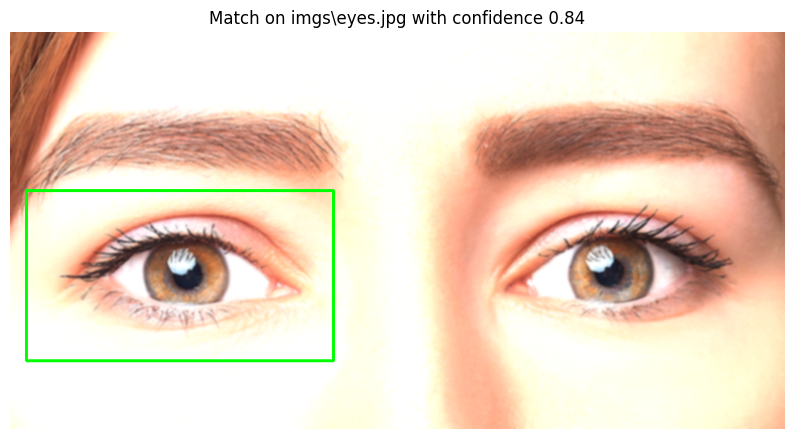

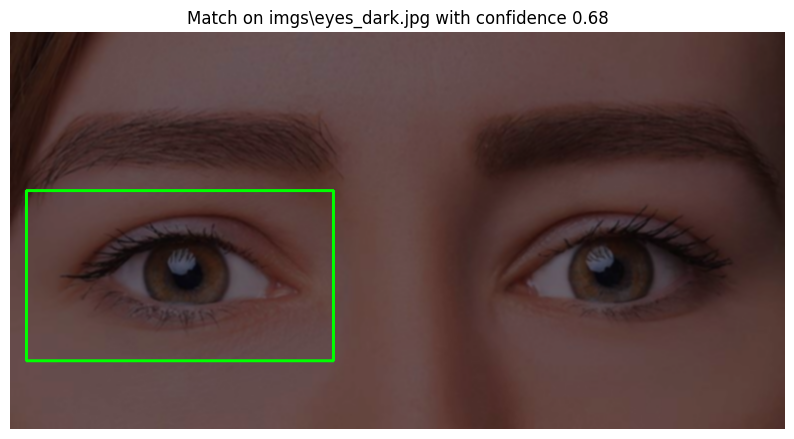

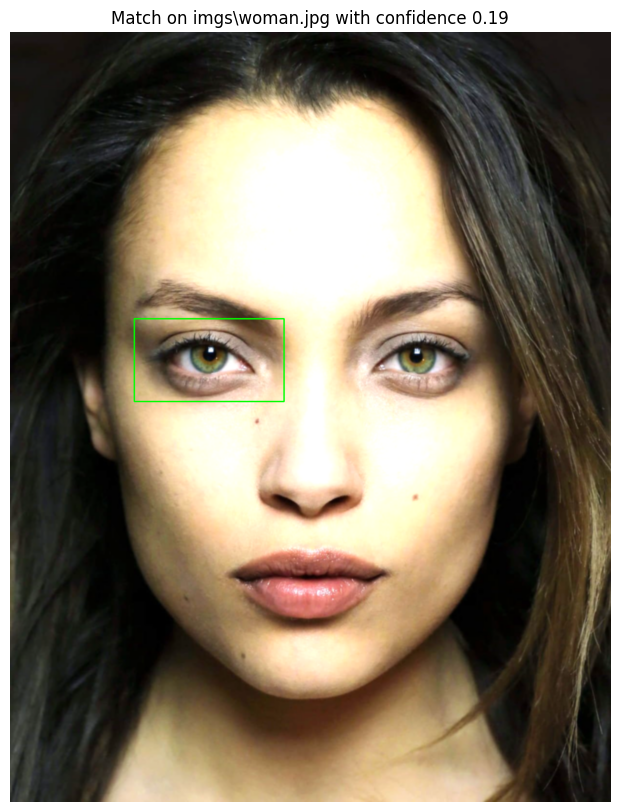

In [9]:
template = cv2.imread(r'imgs\eye.png')
template = preprocess_image(template)
template_fd, _ = compute_hog(template)

images = [r'imgs\eyes.jpg', r'imgs\eyes_dark.jpg', r'imgs\woman.jpg']

for image_name in images:
    image = cv2.imread(image_name)
    image = preprocess_image(image)

    best_location = (0, 0)
    best_value = -np.inf

    for scale_factor in [0.8, 1.0, 1.2]:
        scaled_image = scale_image(image, scale_factor)
        location, value = find_best_match(scaled_image, template_fd, (template.shape[1], template.shape[0]))
        location = (int(location[0] / scale_factor), int(location[1] / scale_factor))

        if value > best_value:
            best_value = value
            best_location = location

    draw_bounding_box(image, best_location, (template.shape[1], template.shape[0]))

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Match on {image_name} with confidence {best_value:.2f}')
    plt.axis('off')
    plt.show()